# Fetching and Processing Data

In [1]:
import json
from fear_and_greed import *
from synchronize_data import *

In [2]:
timeframe = 90
verbose = True

In [8]:
daily_data = fetch_daily_data(timeframe)
mcap_data = fetch_mcap_data(timeframe)
exchange_rate_data = fetch_idr_usd_rate(timeframe)
interest_data = fetch_idr_interest_rate()
bonds_data = fetch_temp_bonds_rate(timeframe)

with open('indices_weight.json') as f:
    weight = json.load(f)

fear_and_greed_index = calculate_fear_and_greed_index(daily_data, mcap_data,
                                                        exchange_rate_data, interest_data,
                                                        bonds_data,
                                                        timeframe, weight)

fear_and_greed_index_equal_weight = calculate_fear_and_greed_index(daily_data, mcap_data,
                                                        exchange_rate_data, interest_data,
                                                        bonds_data,
                                                        timeframe)

one_day_delta = datetime.timedelta(days=1)

fear_and_greed_index['date'] = fear_and_greed_index.index
fear_and_greed_index['date'] = fear_and_greed_index['date'] + one_day_delta
fear_and_greed_index_equal_weight['date'] = fear_and_greed_index_equal_weight.index
fear_and_greed_index_equal_weight['date'] = fear_and_greed_index_equal_weight['date'] + one_day_delta
# fear_and_greed_index['date'] = fear_and_greed_index['date'].apply(lambda x: x.isoformat())


https://openexchangerates.org/api/historical/2024-11-12.json
https://www.bi.go.id/id/statistik/indikator/BI-Rate.aspx


In [26]:
fear_and_greed_index

,momentum,strength,volatility,volume_breadth,safe_haven,exchange_rate,interest_rate,buffett,fear_and_greed_index,date
date,,,,,,,,,,
2024-08-14,50.000000,44.634632,15.896043,24.073202,NaN,NaN,NaN,77.091741,NaN,2024-08-15
2024-08-15,48.008976,44.634632,15.896043,24.073202,50.000000,54.943363,NaN,77.091741,NaN,2024-08-16
2024-08-16,52.030557,44.634632,15.896043,24.073202,80.279705,54.943363,NaN,77.091741,NaN,2024-08-17
2024-08-19,50.623028,44.634632,15.896043,24.073202,48.311666,54.943363,NaN,77.091741,NaN,2024-08-20
2024-08-20,59.124801,44.634632,15.896043,24.073202,64.659581,54.943363,NaN,77.091741,NaN,2024-08-21
...,...,...,...,...,...,...,...,...,...,...
2024-11-06,28.614806,33.631068,19.162414,8.231301,59.641986,97.228026,25.0,64.507298,45.971935,2024-11-07
2024-11-07,28.523235,33.064587,19.518483,5.304965,50.916543,100.000000,25.0,61.088466,45.645802,2024-11-08
2024-11-08,32.024466,34.471494,20.240023,5.568482,44.559929,98.497910,25.0,58.532850,45.872659,2024-11-09


# Plot and Comparison

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## IHSG Price

In [5]:
from dotenv import load_dotenv

load_dotenv()
_SECTORS_API_KEY = os.getenv('SECTORS_API_KEY')

url = 'https://api.sectors.app/v1/index-daily/ihsg/'

today = pd.Timestamp.now()
max_past_date = today - pd.Timedelta(timeframe, 'days')

headers = {
    'Authorization': _SECTORS_API_KEY,
}
params = {
    'start': max_past_date.date().strftime('%Y-%m-%d'),
    'end': today.date().strftime('%Y-%m-%d')
}

response = requests.get(url, params=params, headers=headers)

data = response.json()
ihsg_data = pd.DataFrame.from_records(data)
ihsg_data['date'] = pd.to_datetime(ihsg_data['date']).dt.date

ihsg_data

,index_code,date,price
0,IHSG,2024-08-14,7436.04
1,IHSG,2024-08-15,7409.50
2,IHSG,2024-08-16,7432.09
3,IHSG,2024-08-19,7466.83
4,IHSG,2024-08-20,7533.98
...,...,...,...
59,IHSG,2024-11-06,7383.87
60,IHSG,2024-11-07,7243.86
61,IHSG,2024-11-08,7287.19
62,IHSG,2024-11-11,7266.46


## IHSG price Movement for comparison

### IHSG 7 days SMA

In [6]:
ihsg_df = ihsg_data.copy()

sma_period = 7
min_momentum = -5
max_momentum = 5

# Calculate SMA
ihsg_df['sma'] = ihsg_df['price'].transform(
    lambda x: x.rolling(window=sma_period, min_periods=1).mean())

# Calculate the percentage difference from the SMA
# Small constant to avoid division by zero
epsilon = 1e-9
ihsg_df['price_sma'] = ((ihsg_df['price'] - ihsg_df['sma']) / (
        ihsg_df['sma'] + epsilon)) * 100

# Remove any NaNs in case any
ihsg_df = ihsg_df.dropna(subset=['price_sma'])

# Scale the momentum to a 0-100 range for the Fear and Greed Index
ihsg_df['sma_scaled'] = ihsg_df['price_sma'].apply(
    lambda x: scale_to_100(x, min_momentum, max_momentum))

# Calculate the Market Momentum Index on a daily basis
ihsg_df[['date', 'sma_scaled']]

,date,sma_scaled
0,2024-08-14,50.000000
1,2024-08-15,48.212258
2,2024-08-16,50.836714
3,2024-08-19,54.130517
4,2024-08-20,60.500976
...,...,...
59,2024-11-06,32.438283
60,2024-11-07,20.501044
61,2024-11-08,31.616695
62,2024-11-11,34.651962


### IHSG daily diff

In [27]:
# ihsg_diff_df = ihsg_data.copy()

# # Calculate average diff
# ihsg_diff_df['diff'] = ihsg_diff_df['price'].diff()

# ihsg_diff_df['diff_scaled'] = ihsg_diff_df.apply(
#     lambda x: x['diff'] / x['price']
# )

# # Calculate the Market Momentum Index on a daily basis
# ihsg_diff_df[['date', 'diff_scaled']]

In [23]:
ihsg_scaled = ihsg_data.copy()
scaler = MinMaxScaler(feature_range=(0, 100))
ihsg_scaled['price_scaled'] = scaler.fit_transform(ihsg_scaled[['price']])

ihsg_scaled

,index_code,date,price,price_scaled
0,IHSG,2024-08-14,7436.04,29.050837
1,IHSG,2024-08-15,7409.50,25.038925
2,IHSG,2024-08-16,7432.09,28.453736
3,IHSG,2024-08-19,7466.83,33.705199
4,IHSG,2024-08-20,7533.98,43.855910
...,...,...,...,...
59,IHSG,2024-11-06,7383.87,21.164573
60,IHSG,2024-11-07,7243.86,0.000000
61,IHSG,2024-11-08,7287.19,6.549967
62,IHSG,2024-11-11,7266.46,3.416323


### Plot

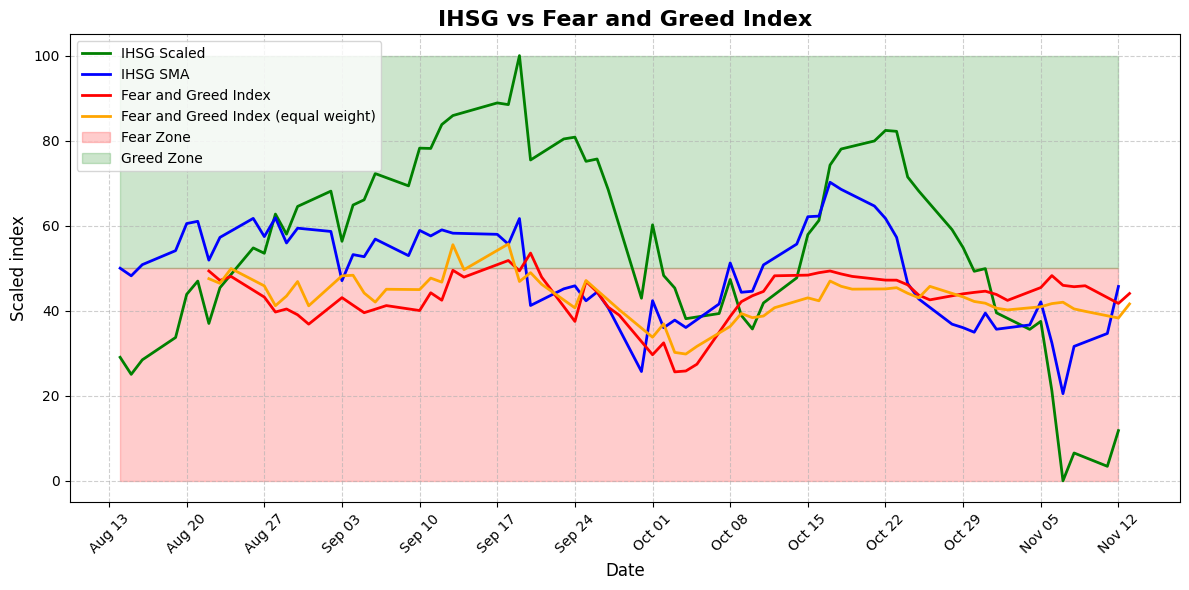

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the Buffett Indicator over time
ax.plot(ihsg_scaled['date'], ihsg_scaled['price_scaled'], color='green', linewidth=2, label='IHSG Scaled')
ax.plot(ihsg_df['date'], ihsg_df['sma_scaled'], color='blue', linewidth=2, label='IHSG SMA')

ax.plot(fear_and_greed_index['date'], fear_and_greed_index['fear_and_greed_index'], color='red', linewidth=2, label='Fear and Greed Index')
ax.plot(fear_and_greed_index_equal_weight['date'],
        fear_and_greed_index_equal_weight['fear_and_greed_index'], color='orange', linewidth=2, label='Fear and Greed Index (equal weight)')

# Highlight Fear and Greed zones (Assuming > 50 is Greed and < 50 is Fear for demonstration)
ax.fill_between(ihsg_df['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(ihsg_df['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Set x-axis to show dates on a weekly basis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Set dates to show weekly
plt.xticks(rotation=45)

# Adding labels and title
plt.title("IHSG vs Fear and Greed Index", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled index", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()